# Estimating Home Value:

**Project Goal:** The goal of this project is to build an improved model for predicting property tax assessed values for Single Family Properties.  Accurate property value predictions are crucial to our business operations and maintaining our customer base.

In [1]:
#the basics
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

#viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='colorblind')

#modeling and stats
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE

#My modules
import wrangle
import utils

***
## Data Acquisition
***

Data is acquired from the zillow database on the codeup server

In [2]:
#Retrieve data
df = wrangle.getZillowData()

***
## Data Preparation
***

**Cleaning performed in the data preparation function:**
- Created new feature sf/bed
  - 0 bedrooms treated as 1 bedroom
- 2% of the data was dropped.  Rows were dropped if:
  - There were any nulls
  - It fell in the top 1% of square footage
  - It had < 120 square feet 
  - There were less than 30 rows with the same zip code
  - There were 9+ beds or 9+ baths
  - There were zero baths
  - The value was >= 2 million
  - sf/bed was < 200 or >1500
- Bed, yearbuilt, square footage and value were converted to integers
- zipcode was converted to a string
- fips was mapped to a readable column
- zipcode and fips were encoded
- columns were reorganized so that target and categorical were at the beginning, with encoded columns at the end

In [3]:
#Prep and split the data into 70/15/15 (train/test/validate)
tr, te, val = wrangle.prep_zillow(df,include_zip=True,val_ratio=.15,test_ratio=.15)

***
## Exploration
***
*More exploration can be found in explore.ipynb*

In [4]:
#generate a training subset without encoded columns
tr_eda = tr.iloc[:,:8]

Show distribution of target variable


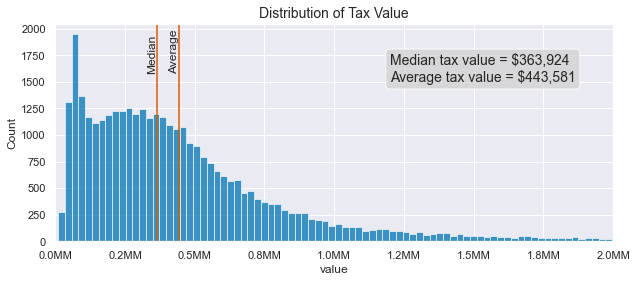

In [5]:
#get stats
med = tr_eda.value.median()
avg = tr_eda.value.mean()
#initialize figure
fig, ax = plt.subplots(figsize=(10,4))
ax = sns.histplot(data=tr_eda,x='value')
#add lines and text
ax.axvline(med,c='r')
ax.text(med-35000,1600,'Median',rotation=90)
utils.xticks_mm(ax)
ax.set_xlim((0,2_000_000));
ax.axvline(avg,c='r')
ax.text(avg-35000,1600,'Average',rotation=90)
plt.title('Distribution of Tax Value',fontsize=14)
#print values in text box
props = dict(boxstyle='round', facecolor='lightgrey',alpha=0.8)
textstr = f'Median tax value = ${med:,.0f}\nAverage tax value = ${avg:,.0f}'
ax.text(1_200_000,1500, textstr, fontsize=14,bbox=props);

### Does county impact tax value?

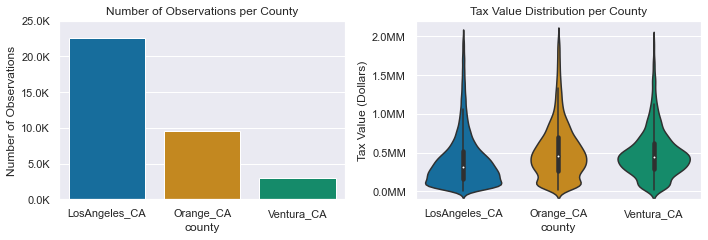

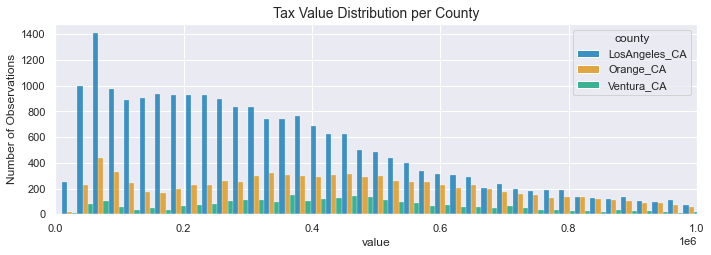

In [6]:
#Does county impact tax value
display(Markdown('### Does county impact tax value?'))
plt.figure(figsize=(10,3.5)) #initialize figure
plt.subplot(121) #begin plotting
ax = sns.countplot(x=tr_eda.county);
utils.yticks_k(ax) #pretty print y axis & title
plt.title('Number of Observations per County')
plt.ylabel('Number of Observations')
plt.subplot(122) #Begin plot 2
ax = sns.violinplot(data = tr_eda,x='county',y='value');
utils.yticks_mm(ax) #pretty print y axis & title
ax.set_ylim((-100_000,2_200_000));
plt.title('Tax Value Distribution per County')
plt.ylabel('Tax Value (Dollars)')
plt.tight_layout()
plt.figure(figsize=(11.5,3.5)) #Add Final plot (3)
ax = sns.histplot(data=tr_eda, x='value',hue='county',multiple='dodge')
plt.title('Tax Value Distribution per County',fontsize=14)
plt.ylabel('Number of Observations')
ax.set_xlim((0,1_000_000));

##### Perform ANOVA analysis of variance

In [7]:
#Normalish (but skewed) and large number of values.  Variance are not to disimilar
values_la = tr_eda[tr_eda.county == 'LosAngeles_CA'].value
values_orange = tr_eda[tr_eda.county == 'Orange_CA'].value
values_ventura = tr_eda[tr_eda.county == 'Ventura_CA'].value
f, p = stats.f_oneway(values_la,values_orange,values_ventura)
h0='the population means of tax values for the three counties are equal'
utils.stats_result(p,h0,f=f)


H₀: the population means of tax values for the three counties are equal
We reject the null hypothesis, p = 8.95552891726163e-195 | α = 0.05


**NOTES:** There are more observations in LA County.  Both Orange and Ventura counties have a larger concentration of home values around 300-500k, whereas LA shows higher concentrations from 100k to 400k. We see that LA has a significantly lower median. With further statistical analysis, I was able to reject the null hypothesis that mean tax values for these counties are equal.

### Does zip code impact tax value?

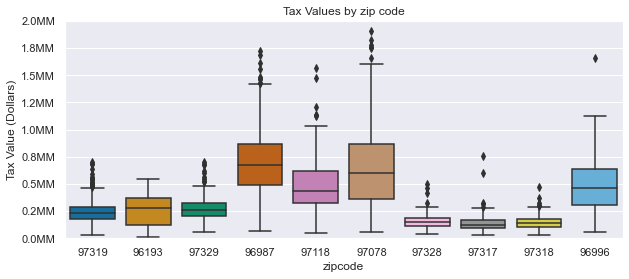

In [8]:
# Does zip code impact tax value?
display(Markdown('### Does zip code impact tax value?'))
#Make a subset of zipcodes - too many categories to visualize easily
zip_cnt = tr_eda.zipcode.value_counts()
#Look at the 10 zip codes with the most observations
tr_eda_top10zip = tr_eda[tr_eda.zipcode.isin(zip_cnt.nlargest(n=10).index)]

#Create box plot
plt.figure(figsize=(10,4))
ax = sns.boxplot(data=tr_eda_top10zip, y='value',x='zipcode')
ax.set(title='Tax Values by zip code',ylabel='Tax Value (Dollars)',ylim=(0,2000000))
utils.yticks_mm(ax)

**NOTES:** These zip code subsets show notable differences in tax value.  This will likely be very useful if it can be properly incorporated into the model.

### Do square footage and number of bedrooms correlate well with tax value?

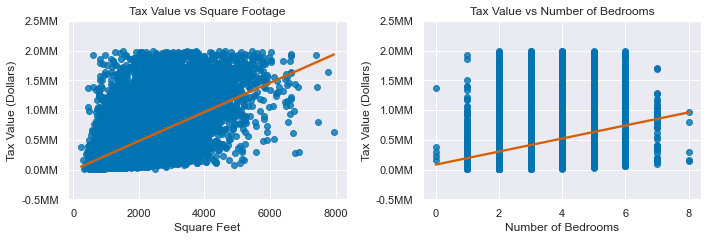

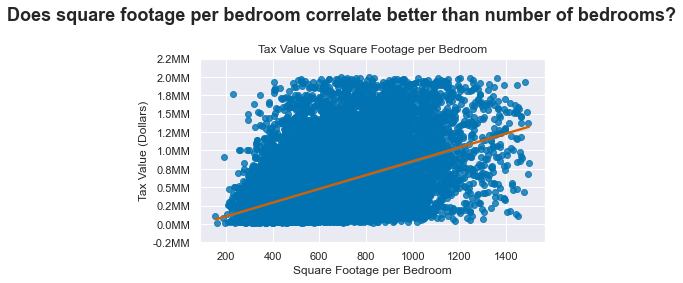

In [9]:
display(Markdown('### Do square footage and number of bedrooms correlate well with tax value?'))
plt.figure(figsize=(10,3.5)) #initialize figure
plt.subplot(121) #begin plotting
ax = sns.regplot(data=tr_eda,x='sf',y='value',line_kws={'color':'r'},);
ax.set(title='Tax Value vs Square Footage',ylabel='Tax Value (Dollars)',xlabel='Square Feet')
utils.yticks_mm(ax) #pretty print y axis & title
plt.subplot(122) #Begin plot 2
ax = sns.regplot(data=tr_eda,x='bed',y='value',line_kws={'color':'r'});
ax.set(title='Tax Value vs Number of Bedrooms',ylabel='Tax Value (Dollars)',xlabel='Number of Bedrooms')
utils.yticks_mm(ax) #pretty print y axis & title
plt.tight_layout()
#new question and plot
# display(Markdown('### Does sf_per_bed correlate better than number of bedrooms?'))
fig, ax = plt.subplots(1,1)
fig.suptitle('Does square footage per bedroom correlate better than number of bedrooms?',fontsize=18,fontweight='bold')
ax = sns.regplot(data=tr_eda,x='sf_per_bed',y='value',line_kws={'color':'r'});
ax.set(title='Tax Value vs Square Footage per Bedroom',ylabel='Tax Value (Dollars)',xlabel='Square Footage per Bedroom')
utils.yticks_mm(ax) #pretty print y axis & title
plt.tight_layout()

**NOTES:** Above there seems to be some small correlation between the number of bedrooms and value.  Looking at the other two charts, there appears to be a greater correlation between value and both square feet and square feet per bedroom.

#####  Run a Pearson R test for correlation

In [10]:
for f in ['bed', 'sf', 'sf_per_bed']:
    h0 = f'There is no linear correlation between {f}  and the tax value of a property'
    corr, p = stats.pearsonr(tr_eda.value,tr_eda[f])
    #use default alpha of .05
    utils.stats_result(p,h0,corr=corr)


H₀: There is no linear correlation between bed  and the tax value of a property
We reject the null hypothesis, p = 0.0 | α = 0.05
  corr: 0.28004401550519165

H₀: There is no linear correlation between sf  and the tax value of a property
We reject the null hypothesis, p = 0.0 | α = 0.05
  corr: 0.5769236080799727

H₀: There is no linear correlation between sf_per_bed  and the tax value of a property
We reject the null hypothesis, p = 0.0 | α = 0.05
  corr: 0.49537651101057245


**Notes:** All variables have some correlation, however the tax value's correlation to the number of bedrooms is relatively weak, where as the correlation to square footage and square footage per bedroom is much higher at .58 and .50, respectively.

***
## Modeling
***
Regression Models:
- 16 linear regression using two scaling techniques and a range of inputs
- 36 Generalized linear models using a range of best features and alphas
- 6 Lassolars using a range of alphas


##### Prepare model inputs

In [11]:
#Performa Min Max Sclaer on continuous independent variables
tr_mm, te_mm, val_mm = wrangle.scale_zillow(tr,te,val)

#split the train subset
#all contains zip, X_tr contains all but zip, y_tr is target
X_tr_mm_all = tr_mm.iloc[:,3:]
X_te_mm_all = te_mm.iloc[:,3:]
X_val_mm_all = val_mm.iloc[:,3:]
#target variables aren't scaled, so always the same
y_tr = tr.value
y_te = te.value
y_val = val.value

#create results dataframes
tr_res = pd.DataFrame(tr.value)
tr_res.rename(columns={'value':'actual'},inplace=True)
val_res = pd.DataFrame(val.value)
val_res.rename(columns={'value':'actual'},inplace=True)

#Create Baseline - mean performed better than median
tr_res['baseline'] = tr.value.mean()
val_res['baseline'] = tr.value.mean()

##### Recreate top performing models
['lr_mm_kall','ll_a1','pow1_k15_a1','pow1_k6_a1']

In [12]:
#initialize model dictionary and performance
model_dict ={}
mod_perf = pd.DataFrame()
#start with all columns
k_best = X_tr_mm_all.columns

#LINEAR REGRESSION
model_name = 'lr_mm_kall'
#create and store model
model = LinearRegression(normalize=True).fit(X_tr_mm_all,y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model,
    "kbest":k_best}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mm_all[k_best])
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = round(utils.rmse(tr_res.actual,tr_res[model_name]))
mod_perf.loc[model_name,'r2'] = round(r2_score(tr_res.actual,tr_res[model_name]),3)


#LASSO LARS
model_name = 'll_a1'
#create and store model
model = LassoLars(alpha=1).fit(X_tr_mm_all,y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model,
    "kbest":k_best}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mm_all[k_best])
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = round(utils.rmse(tr_res.actual,tr_res[model_name]))
mod_perf.loc[model_name,'r2'] = round(r2_score(tr_res.actual,tr_res[model_name]),3)


#GENERALIZED LINEAR MODEL -pow1 k6 and 15
model_name = 'glm_pow1_k6'
#get kbest features
k_best = utils.select_kbest(X_tr_mm_all,y_tr,6)
#create and store model
model = TweedieRegressor(power=1,alpha=1).fit(X_tr_mm_all[k_best],y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model,
    "kbest":k_best}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mm_all[k_best])
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = round(utils.rmse(tr_res.actual,tr_res[model_name]))
mod_perf.loc[model_name,'r2'] = round(r2_score(tr_res.actual,tr_res[model_name]),3)
#repeat for k15
model_name = 'glm_pow1_k15'
#get kbest features
k_best = utils.select_kbest(X_tr_mm_all,y_tr,15)
#create and store model
model = TweedieRegressor(power=1,alpha=1).fit(X_tr_mm_all[k_best],y_tr)
model_dict[model_name] = {
    "model_name": model_name,
    "model":model,
    "kbest":k_best}
#store predictions on train
tr_res[model_name] = model.predict(X_tr_mm_all[k_best])
#calculate and store performance
mod_perf.loc[model_name,'rmse'] = round(utils.rmse(tr_res.actual,tr_res[model_name]))
mod_perf.loc[model_name,'r2'] = round(r2_score(tr_res.actual,tr_res[model_name]),3)

mod_perf.sort_values(by='rmse')

,rmse,r2
lr_mm_kall,245130.0,0.515
ll_a1,245250.0,0.515
glm_pow1_k15,279740.0,0.369
glm_pow1_k6,286514.0,0.338


**NOTES:** Of these models, the linear regression model with all features and the lasso lars with an alpha of 1 performed the best with an coffecient of determination of .515.  The General Linearized Models did not perform as well, however they were generated with fewer features and will be worth testing against the validate subset

In [16]:
#Loop over models:
for model_name in mod_perf.index:    
    #grab model from dictionary:
    model = model_dict[model_name]['model']
    k_best = model_dict[model_name]['kbest']
    
    #generate prediction on val dataset - adds new column
    val_res[model_name] = model.predict(X_val_mm_all[k_best])
    
    #calculate and store val model stats 
    mod_perf.loc[model_name,'rmse_val'] = round(utils.rmse(val_res.actual,val_res[model_name]))
    mod_perf.loc[model_name,'r2_val'] = round(r2_score(val_res.actual,val_res[model_name]),3)
    #determine improvement
    mod_perf.loc[model_name,'rmse_diff'] = mod_perf.loc[model_name,'rmse_val'] - mod_perf.loc[model_name,'rmse']
    mod_perf.loc[model_name,'r2_diff'] = mod_perf.loc[model_name,'r2_val'] - mod_perf.loc[model_name,'r2']

mod_perf

,rmse,r2,rmse_val,r2_val,rmse_diff,r2_diff
lr_mm_kall,245130.0,0.515,249194.0,0.510,4064.0,-0.005
ll_a1,245250.0,0.515,249213.0,0.510,3963.0,-0.005
glm_pow1_k6,286514.0,0.338,287833.0,0.346,1319.0,0.008
glm_pow1_k15,279740.0,0.369,281154.0,0.376,1414.0,0.007


**NOTES:** All of the models did well going from train to validate.  The ones with the best performance RMSE and R2 had the greatest loss when moving to validate, however it was still only less than 2% loss in performance. Moving forward, I'll use the lasso lars with an alpha of 1 on the test dataset.

##### Run Lasso Lars on Test subset

RMSE: 247638
r2: 0.508


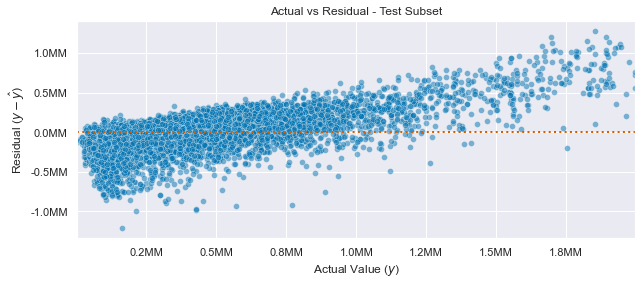

In [14]:
#pull model from dictionary
model = model_dict['ll_a1']['model']
#create test result dataframe and populate with actual values
test_res = pd.DataFrame(y_te)
test_res.rename(columns={'value':'actual'},inplace=True)
#run against model to get predictions and probabilities
test_res['ll_a1'] = model.predict(X_te_mm_all)

stat1 = utils.rmse(test_res.actual,test_res['ll_a1'])
stat2 = r2_score(test_res.actual,test_res['ll_a1'])
#print model performance to screen and store in datafram
print(f'RMSE: {round(stat1)}')
print(f'r2: {round(stat2,3)}')

#calculate residuals
resid = utils.residuals(test_res.actual,test_res.ll_a1)
plt.figure(figsize=(10,4))
# plt.scatter(test_res.actual, resid)
ax = sns.scatterplot(x=test_res.actual, y=resid,alpha=.5)
utils.yticks_mm(ax)
utils.xticks_mm(ax)
ax.set(ylabel='Residual ($y - \hat{y}$)',xlabel='Actual Value ($y$)',title='Actual vs Residual - Test Subset',
       xlim=(test_res.actual.min(), test_res.actual.max()))
plt.hlines(0, test_res.actual.min(), test_res.actual.max(),color='r', ls=':',linewidth=2);

**NOTES:** The Lasso Lars performed well and consistently on the Test subset as well, with an RMSE around 450k and an r2 of .51.  As can be seen in the residual plot, there are still other factors at play that do not appear to be accounted for in the model.

***
# Conclusion
***

**Goals:** Identify key drivers of tax value and develop an optimal model for predicting it.

**Key Findings:**
*see modeling.ipynb for more details*
- Square footage has the highest correlation with tax value (.58), followed by number of baths and square footage per bedroom.
- Counties have statistically significant different tax value means
- The inclusion of more granular geographic data greatly improves model performance. 


**Recommendation:** Include more granular geographic data such as zip code, neighborhood, or census tract

**Future Projects:**
- Try more engineered features:
  - bed+bath
  - sf/(bed+bath)
- Better leverage zip code in models (or other geographic data)
  - Potentially create a model for each zip code
  - Use CAR or ICAR
